In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
from xgboost import XGBClassifier

from warnings import filterwarnings
filterwarnings("ignore")


## Needs further work: 

### classification_report to dataframe
cr = classification_report(y_test, y_pred)
cr_lines = cr.split("\n")
class_names = cr_lines[0].split()
metrics = []
for line in cr_lines[2:-3]: 
    metrics.append(line.split())

cr_df = pd.DataFrame(metrics, columns = ["class"]+ class_names)
cr_df

### standard scaler implementation with pandas
#copy the data
df_min_max_scaled = df.copy()

#apply normalization techniques
for column in df_min_max_scaled.columns:
	df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())	

## Function Definitions

In [68]:
## Print amount of nulls per column
def null_summary(df): 
        for col in df.columns: 
            null_count = df[col].isnull().sum()
            if null_count > 0: 
                print(f"'{col}' : ", null_count, "nulls")

# clean and enumerate credit ratings
def clean_credit_col(df): 
    if(df["CreditRating"].dtypes == "object"): 
        df["CreditRating"] = df["CreditRating"].str[0].astype(int)

# delete negatives from cols that should have only positive ints
def drop_misplaced_negatives(df, excluded_cols = []): 
        numeric_cols = df.select_dtypes(include = ["number"]).drop(columns = excluded_cols)
        filtered_df = numeric_cols.loc[~(numeric_cols < 0). any(axis = 1)]
        df = filtered_df

## Check all customer IDs are unique
def uniqueID_check(df): 
    if (df["CustomerID"].value_counts().sum() == df.shape[0]): 
        print("Customer IDs are unique")


In [167]:
# Plot feature importance (random forest)
def plot_feature_importance_rf(df, rf_model): 
    importances_rf = rf_model.feature_importances_
    feature_labels = df.columns[1:]
    indices = np.argsort(-(importances_rf))

    plt.figure(figsize = (14, 4))
    plt.title("Random Forest: Feature Importance")
    plt.bar(range(len(feature_labels)), 
        importances_rf[indices], 
        align = "center")

    plt.xticks(range(len(feature_labels)), 
           feature_labels[indices], 
           rotation = 90)

    plt.tight_layout()
    plt.show()

def plot_conf_matrix(y_test, y_pred): 
    conf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    labels = [f"{v1}:\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot = labels, linewidths= 0.7, fmt = "", cmap = "flare", annot_kws= {"size": "medium"})
    
    print(classification_report(y_test, y_pred))

# Chi2 feature selection with plot
def chi2_feature_selection(X_train_res, y_train_res, X_test):
    cols_with_neg = X_train_res.columns[X_train_res.lt(0).any()]
    X_train_res_pos = X_train_res.drop(columns=cols_with_neg)
    X_test_pos = pd.DataFrame(X_test, columns=X_train_res.columns).drop(columns=cols_with_neg)

    fs = SelectKBest(chi2, k="all")
    fs.fit(X_train_res_pos, y_train_res)
    X_train_fs = fs.transform(X_train_res_pos)
    X_test_fs = fs.transform(X_test_pos)

    feature_labels = X_train_res_pos.columns
    fs_scores = fs.scores_

    sorted_indices = np.argsort(fs_scores)[::-1]

    print("Feature Importance Scores (Highest to Lowest):")
    for i, idx in enumerate(sorted_indices):
        print('Feature %s: %f' % (feature_labels[idx], fs_scores[idx]))

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(fs_scores)), fs_scores[sorted_indices])
    plt.xticks(range(len(fs_scores)), [feature_labels[idx] for idx in sorted_indices], rotation=90)
    plt.title("Feature Importance Score", size=20)
    plt.xlabel("Features/Variables", size=16, color="black")
    plt.ylabel("Importance Score", size=16, color="black")
    plt.tight_layout()
    plt.show()

### Data Validity Checks

In [69]:
df = pd.read_csv("https://raw.githubusercontent.com/atbalazs/Telecom_Churn_Analysis_and_Forecast/main/cell2cell_data/cell2cell_dataset.csv")

df_copy = df.copy()
df.describe()

,CustomerID,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,...,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating
count,7.104700e+04,70831.000000,70831.000000,70831.000000,70831.000000,70831.000000,70831.000000,70545.000000,70545.000000,71047.000000,...,71046.000000,71046.000000,71046.000000,69803.000000,69803.000000,71047.000000,71047.000000,71047.000000,71047.000000,71047.000000
mean,3.201948e+06,58.852853,525.726250,46.862899,0.894817,40.087730,1.222315,-10.845304,-1.204730,6.009567,...,1.808617,1.561791,380.265631,31.375113,21.157715,0.037004,0.017918,0.050854,4.334229,0.053162
std,1.167965e+05,44.243566,530.136184,23.915000,2.197577,96.349599,9.081089,255.314034,38.770236,9.006656,...,1.336120,0.908280,254.294692,22.082195,23.917586,0.205823,0.141485,0.290444,3.137063,0.374988
min,3.000002e+06,-6.170000,0.000000,-11.000000,0.000000,0.000000,0.000000,-3875.000000,-1107.700000,0.000000,...,1.000000,1.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.100576e+06,33.640000,158.000000,30.000000,0.000000,0.000000,0.000000,-83.000000,-7.100000,0.700000,...,1.000000,1.000000,204.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,3.201478e+06,48.530000,366.000000,45.000000,0.250000,2.000000,0.000000,-5.000000,-0.300000,3.000000,...,1.000000,1.000000,330.000000,36.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
75%,3.304918e+06,71.030000,722.000000,60.000000,0.990000,41.000000,0.300000,66.000000,1.600000,7.700000,...,2.000000,2.000000,515.000000,48.000000,42.000000,0.000000,0.000000,0.000000,7.000000,0.000000
max,3.399994e+06,1223.380000,7668.000000,400.000000,159.390000,4321.000000,1112.400000,5192.000000,2483.500000,221.700000,...,28.000000,16.000000,1823.000000,99.000000,99.000000,4.000000,4.000000,35.000000,9.000000,25.000000


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71047 entries, 0 to 71046
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 71047 non-null  int64  
 1   Churn                      51047 non-null  object 
 2   MonthlyRevenue             70831 non-null  float64
 3   MonthlyMinutes             70831 non-null  float64
 4   TotalRecurringCharge       70831 non-null  float64
 5   DirectorAssistedCalls      70831 non-null  float64
 6   OverageMinutes             70831 non-null  float64
 7   RoamingCalls               70831 non-null  float64
 8   PercChangeMinutes          70545 non-null  float64
 9   PercChangeRevenues         70545 non-null  float64
 10  DroppedCalls               71047 non-null  float64
 11  BlockedCalls               71047 non-null  float64
 12  UnansweredCalls            71047 non-null  float64
 13  CustomerCareCalls          71047 non-null  flo

In [71]:
# checking nulls - 20,000 rows without label - fewer than 2% of nontarget rows with null, dropping all null for simplicity
null_summary(df)
print("Rows before drop all null: ", df.shape[0])
print("Rows after drop all null: ", df.dropna().shape[0])

'Churn' :  20000 nulls
'MonthlyRevenue' :  216 nulls
'MonthlyMinutes' :  216 nulls
'TotalRecurringCharge' :  216 nulls
'DirectorAssistedCalls' :  216 nulls
'OverageMinutes' :  216 nulls
'RoamingCalls' :  216 nulls
'PercChangeMinutes' :  502 nulls
'PercChangeRevenues' :  502 nulls
'ServiceArea' :  28 nulls
'Handsets' :  1 nulls
'HandsetModels' :  1 nulls
'CurrentEquipmentDays' :  1 nulls
'AgeHH1' :  1244 nulls
'AgeHH2' :  1244 nulls
Rows before drop all null:  71047
Rows after drop all null:  49752


In [72]:
df.dropna(inplace = True)

## Type conversion
df["HandsetModels"] = df["HandsetModels"].astype("object")
df["Handsets"] = df["Handsets"].astype(int)

# remove neg values in positive-int cols
drop_misplaced_negatives(df, excluded_cols = ["PercChangeMinutes", "PercChangeRevenues"])

In [73]:
for col in df.columns: 
        if df[col].dtype == "object": 
                print(df[col].value_counts())

Churn
No     35507
Yes    14245
Name: count, dtype: int64
ServiceArea
NYCBRO917    1646
DALDAL214    1479
HOUHOU281    1471
NYCMAN917    1156
DALFTW817     771
             ... 
SANROM956       1
INDCRA765       1
SEWSUN509       1
ATLDBL478       1
NCRDNN910       1
Name: count, Length: 743, dtype: int64
HandsetModels
1.0     31078
2.0     12691
3.0      4023
4.0      1255
5.0       428
6.0       171
7.0        58
8.0        23
9.0        16
10.0        6
11.0        1
15.0        1
14.0        1
Name: count, dtype: int64
ChildrenInHH
No     37483
Yes    12269
Name: count, dtype: int64
HandsetRefurbished
No     42852
Yes     6900
Name: count, dtype: int64
HandsetWebCapable
Yes    44905
No      4847
Name: count, dtype: int64
TruckOwner
No     40280
Yes     9472
Name: count, dtype: int64
RVOwner
No     45619
Yes     4133
Name: count, dtype: int64
Homeownership
Known      33725
Unknown    16027
Name: count, dtype: int64
BuysViaMailOrder
No     31432
Yes    18320
Name: count, dtype: int64

In [74]:
clean_credit_col(df)

df.drop(["HandsetPrice", "NotNewCellphoneUser"], axis = 1, inplace = True)

## Data Visualization

<Axes: >

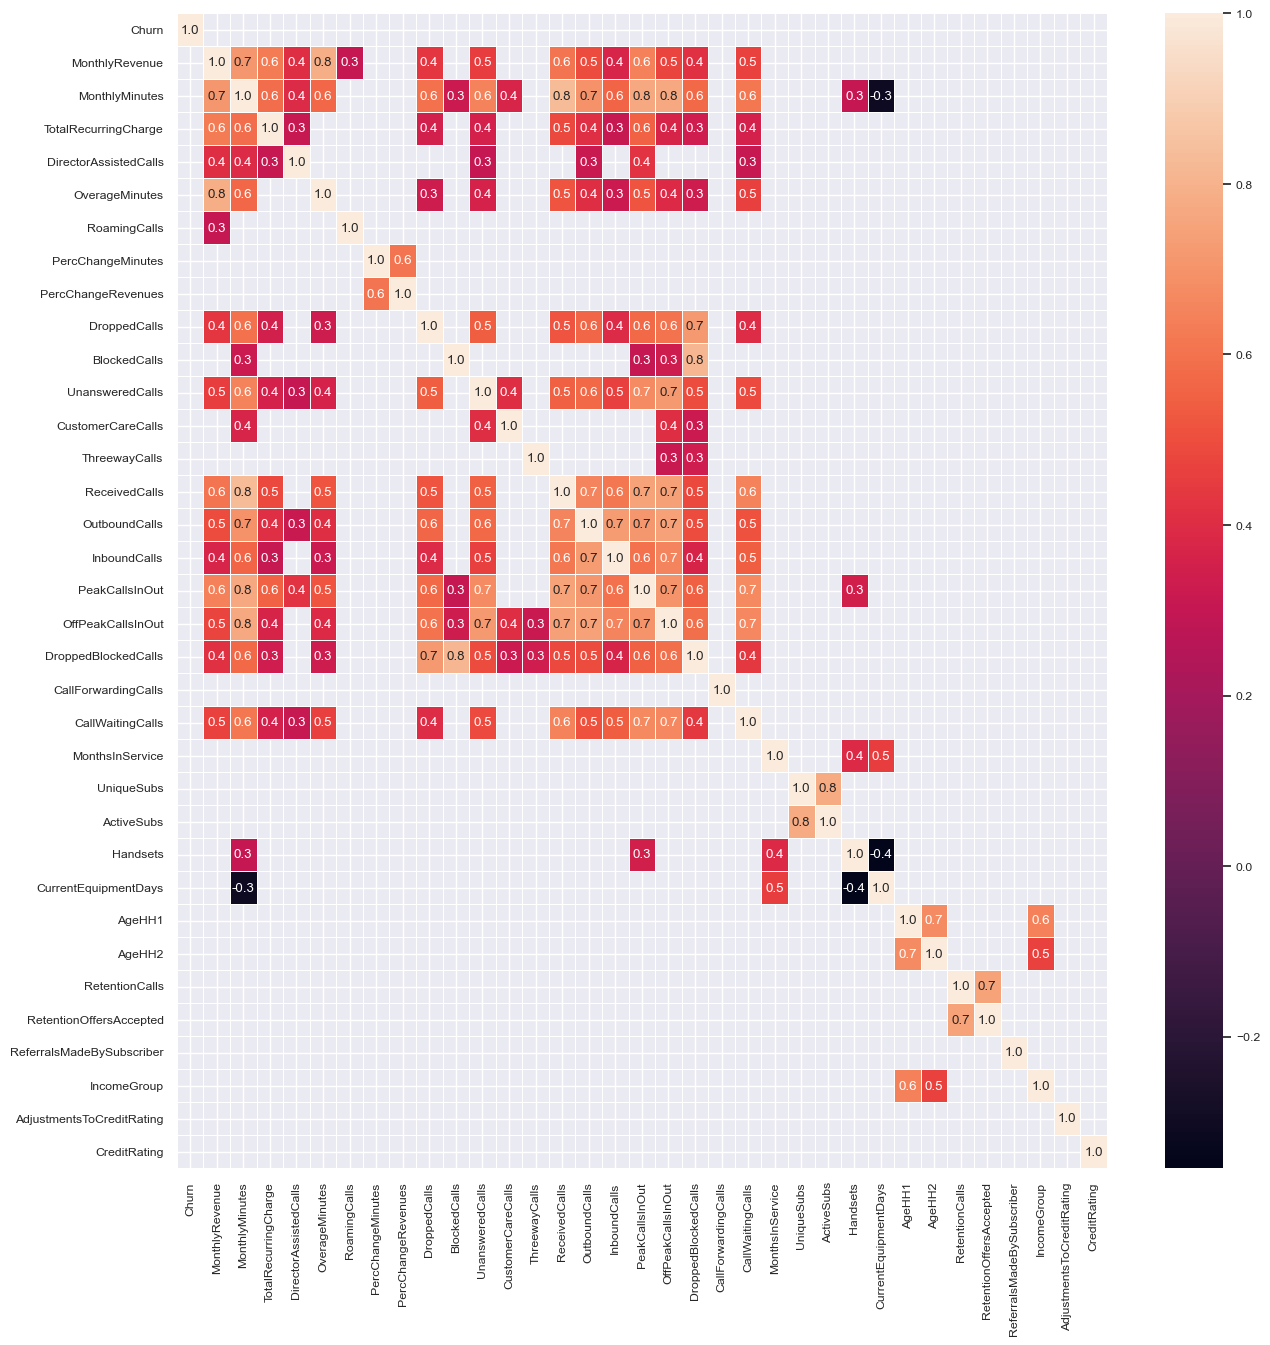

In [75]:
# Heatmap (corr > 0.3 || corr < -0.3)
sns.set_style("dark")
sns.set(font_scale = 0.8)
f, ax = plt.subplots(figsize= (15, 15))
sns.heatmap(df_numerical.corr(), annot = True, fmt = ".1f", linewidths= 0.5, mask = df_numerical.corr().abs() < 0.3)

## Data Pre-Processing

In [87]:
# Check data balancing
df["Churn"].value_counts()

Churn
0    35507
1    14245
Name: count, dtype: int64

In [76]:
df_numerical = df.select_dtypes(include = "number")
df_categorical = df.select_dtypes(exclude = "number")

# Copying then dropping customerID as feature
customerIDs = df["CustomerID"]
df.drop("CustomerID", axis = 1, inplace = True)

In [77]:
# Encode churn values: 
churn_mapping = {"Yes": 1, "No": 0}
df["Churn"] = df["Churn"].map(churn_mapping)

# Label encoder
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df[df_categorical.columns.tolist()] = df[df_categorical.columns.tolist()].apply(LabelEncoder().fit_transform)

# Check for all cols being numeric
(df.dtypes == "object").any()

False

In [78]:
# Train-test-split
from sklearn.model_selection import train_test_split
X = df.drop("Churn", axis = 1)
y = df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)

In [285]:
# Feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [88]:
# Upsample using SMOTE with KNN
from imblearn.over_sampling import SMOTE
sm_resampler = SMOTE(random_state = 1, k_neighbors = 5)
X_train_res, y_train_res = sm_resampler.fit_resample(X_train, y_train)

# Check resample balancing
np.unique(y_train_res, return_counts = True)[1]

# Save preprocessed data locally


## Basic Logistic Regression Model

              precision    recall  f1-score   support

           0       0.76      0.58      0.66     10652
           1       0.34      0.55      0.42      4274

    accuracy                           0.57     14926
   macro avg       0.55      0.57      0.54     14926
weighted avg       0.64      0.57      0.59     14926



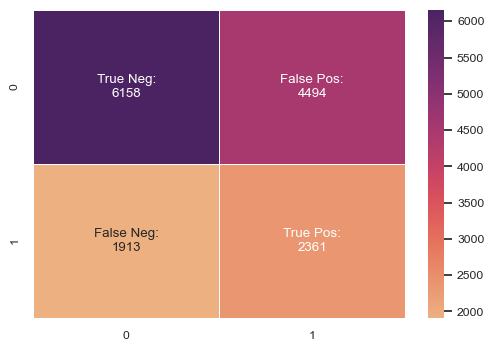

In [232]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty = "l2", random_state = 1, solver = "lbfgs")
clf_lr.fit(X_train_res, y_train_res)
y_pred_lr = clf_lr.predict(X_test)

plot_conf_matrix(y_test, y_pred_lr)

## KNN Model

In [ ]:
# implement KNN 

## Random Forest Model

              precision    recall  f1-score   support

           0       0.74      0.89      0.81     10652
           1       0.42      0.20      0.28      4274

    accuracy                           0.69     14926
   macro avg       0.58      0.55      0.54     14926
weighted avg       0.65      0.69      0.65     14926



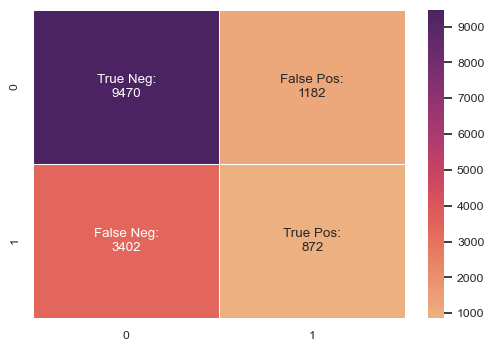

In [409]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 200, random_state = 1)
clf_rf = rf.fit(X_train_res, y_train_res)
y_pred_rf = clf_rf.predict(X_test)

plot_conf_matrix(y_test, y_pred_rf)

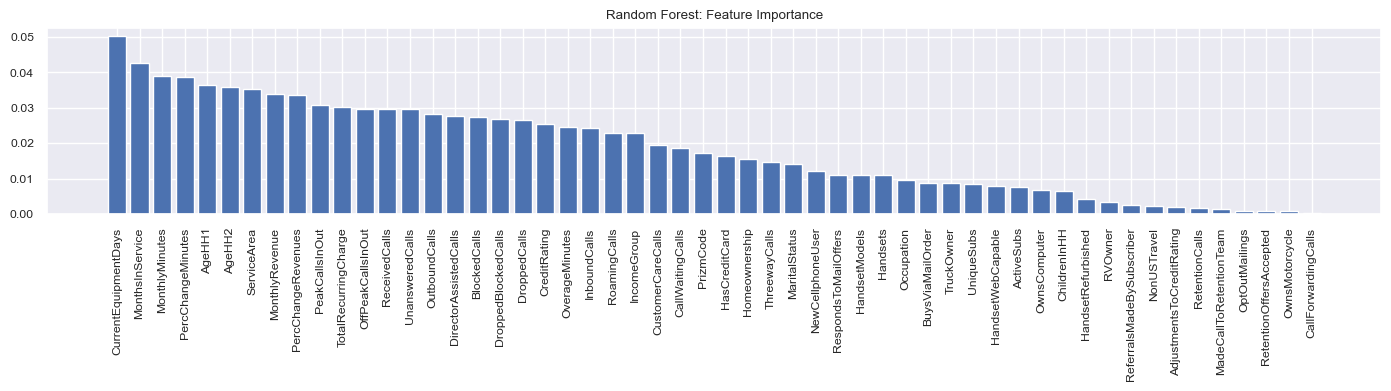

In [411]:
plot_feature_importance_rf(df, clf_rf)

## XGBoost Model

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END colsample_bytree=0.4, eta=0.7, gamma=1, max_depth=9, min_child_weight=1, subsample=0.6;, score=0.755 total time=   1.9s
[CV 2/5] END colsample_bytree=0.4, eta=0.7, gamma=1, max_depth=9, min_child_weight=1, subsample=0.6;, score=0.749 total time=   1.9s
[CV 3/5] END colsample_bytree=0.4, eta=0.7, gamma=1, max_depth=9, min_child_weight=1, subsample=0.6;, score=0.752 total time=   1.9s
[CV 4/5] END colsample_bytree=0.4, eta=0.7, gamma=1, max_depth=9, min_child_weight=1, subsample=0.6;, score=0.752 total time=   1.9s
[CV 5/5] END colsample_bytree=0.4, eta=0.7, gamma=1, max_depth=9, min_child_weight=1, subsample=0.6;, score=0.762 total time=   1.9s
[CV 1/5] END colsample_bytree=0.6, eta=0.5, gamma=3, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.778 total time=   1.1s
[CV 2/5] END colsample_bytree=0.6, eta=0.5, gamma=3, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.769 total time=   1.1s
[CV 3/5

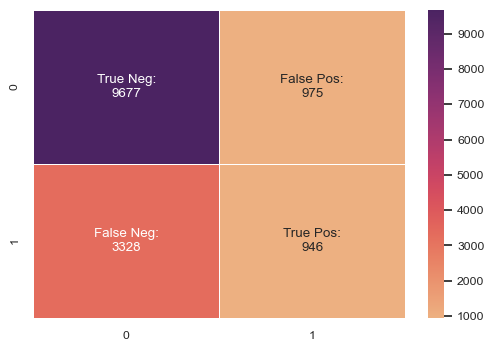

In [469]:
xgb_params = {
    "eta": [0.1, 0.3, 0.5, 0.7],
    "gamma": [0.5, 1, 3, 5],
    "max_depth" : [2, 5, 9],
    "min_child_weight" : [0.5, 1, 5, 10],
    "subsample" : [0.4, 0.6, 0.8], 
    "colsample_bytree" : [0.4, 0.6, 0.8]
}

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)

rs_model = RandomizedSearchCV(estimator = XGBClassifier(), 
                              param_distributions = xgb_params, 
                              n_iter = , 
                              scoring = "accuracy", 
                              cv = skf, 
                              verbose = 3)

rs_model.fit(X_train_res, y_train_res)

print(rs_model.best_params_)
print(rs_model.best_score_)
xgb_params_optimized = rs_model.best_params_

xgb = XGBClassifier(**xgb_params_optimized)
clf_xgb = xgb.fit(X_train_res, y_train_res)
y_pred_xgb = xgb.predict(X_test)

plot_conf_matrix(y_test, y_pred_xgb)

## Neural Net Build

In [471]:
from keras import regularizers

tf.random.set_seed(1)
hidden_units = 100
learning_rate = 0.01
num_classes = (X_train.shape[1], )

nn = keras.Sequential()
# nn.add(Dense(hidden_units, input_dim = X_train.shape[1], activation = "tanh"))
nn.add(Dense(hidden_units, input_dim = X_train.shape[1], activation = "relu", kernel_regularizer = regularizers.l1(0.01)))
nn.add(Dense(hidden_units, activation = "tanh"))
nn.add(Dense(1, activation = "sigmoid"))

sgd = optimizers.legacy.SGD(lr = learning_rate)
nn.compile(loss = "binary_crossentropy", optimizer = sgd, metrics = ["accuracy"])

In [472]:
nn.fit(X_train_res, y_train_res, epochs = 5)

Epoch 1/5
   9/1554 [..............................] - ETA: 10s - loss: 6.0126 - accuracy: 0.5764 

2023-08-27 17:07:03.028063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1554/1554 [==============================] - 7s 4ms/step - loss: 2.9519 - accuracy: 0.5374
Epoch 2/5
1554/1554 [==============================] - 7s 4ms/step - loss: 0.7547 - accuracy: 0.5330
Epoch 3/5
1554/1554 [==============================] - 7s 4ms/step - loss: 0.7321 - accuracy: 0.5332
Epoch 4/5
1554/1554 [==============================] - 7s 4ms/step - loss: 0.7248 - accuracy: 0.5349
Epoch 5/5
1554/1554 [==============================] - 7s 4ms/step - loss: 0.7287 - accuracy: 0.5336


In [473]:
eliminated_features = np.where(nn.layers[0].get_weights()[0].any(axis=1) == 0)[0]
print(f'Eliminated features: {eliminated_features}')

Eliminated features: []


In [429]:
nn1.evaluate(X_test, y_test)

467/467 [==============================] - 1s 3ms/step - loss: 7.0354 - accuracy: 0.0000e+00


[7.035449028015137, 0.0]